### Inference Code for the 1D time-dependent PDEs

Here we present the Unisolver's inference code on the 1D time-dependent PDEs to illustrate Unisolver's overall design. We propose the example code to solve 4 equations:
- The Advection function with periodic boundary conditions
- The Viscous Burgers' Equation with periodic boundary conditions
- The Diffusion-reaction function with periodic boundary conditions
- A general form 1D PDE with non-periodic boundary conditions

You can also modify the PDE configurations and solve new PDE instances. The general form of PDEs that Unisolver is currently able to solve can be found in Appendix G.2.

Link to the model checkpoint: https://drive.google.com/file/d/1DTY4LNjPEoR4d1tH7118RzQr29OjFPYZ/view?usp=share_link

In [1]:
import torch
import numpy as np
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def modulate_inr(x, shift, scale):
    return x * (1 + scale[:, None, :]) + shift[:, None, :]

def modulate(x, shift, scale):
    return x * (1 + scale) + shift


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers_x = nn.ModuleList([])
        self.layers_c = nn.ModuleList([])
        for _ in range(depth):
            self.layers_x.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout),
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(dim//4, 6 * dim // 2, bias=True)
                ),
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(dim//4, 6 * dim // 2, bias=True)
                ),
                nn.LayerNorm(dim),
                nn.LayerNorm(dim),
            ]))

        for i in range(depth):
            nn.init.zeros_(self.layers_x[i][2][1].weight)
            nn.init.zeros_(self.layers_x[i][2][1].bias)
            nn.init.zeros_(self.layers_x[i][3][1].weight)
            nn.init.zeros_(self.layers_x[i][3][1].bias)
                  
    def forward(self, x, field, coeff):
        for attn, ff, adaLN_modulation_coeff, adaLN_modulation_field, norm1, norm2 in self.layers_x:
            shift_msa_coeff, scale_msa_coeff, gate_msa_coeff, shift_mlp_coeff, scale_mlp_coeff, gate_mlp_coeff = adaLN_modulation_coeff(coeff).chunk(6, dim=-1)
            shift_msa_field, scale_msa_field, gate_msa_field, shift_mlp_field, scale_mlp_field, gate_mlp_field = adaLN_modulation_field(field).chunk(6, dim=-1)
            
            x_attn = attn(modulate(norm1(x), torch.cat([shift_msa_field, shift_msa_coeff],dim=-1), torch.cat([scale_msa_field, scale_msa_coeff],dim=-1)))
            x = x + torch.cat([gate_msa_field, gate_msa_coeff],dim=-1) * x_attn
            x = x + torch.cat([gate_mlp_field, gate_mlp_coeff],dim=-1) * ff(modulate(norm2(x), torch.cat([shift_mlp_field, shift_mlp_coeff],dim=-1), torch.cat([scale_mlp_field, scale_mlp_coeff],dim=-1)))
        return x
    
class FinalLayer(nn.Module):
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * out_channels, bias=True)
        self.adaLN_modulation_field = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size//4, hidden_size, bias=True)
        )
        
        self.adaLN_modulation_coeff = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size//4, hidden_size, bias=True)
        )

        nn.init.constant_(self.adaLN_modulation_field[-1].weight, 0)
        nn.init.constant_(self.adaLN_modulation_field[-1].bias, 0)
        nn.init.constant_(self.adaLN_modulation_coeff[-1].weight, 0)
        nn.init.constant_(self.adaLN_modulation_coeff[-1].bias, 0)
        nn.init.constant_(self.linear.weight, 0)
        nn.init.constant_(self.linear.bias, 0)

    def forward(self, x, field, coef):
        shift_field, scale_field = self.adaLN_modulation_field(field).chunk(2, dim=-1)
        shift_coeff, scale_coeff = self.adaLN_modulation_coeff(coef).chunk(2, dim=-1)
        x = modulate(self.norm_final(x), torch.cat([shift_field, shift_coeff],dim=-1), torch.cat([scale_field, scale_coeff],dim=-1))
        x = self.linear(x)
        return x
    

class my_INR(nn.Module):
    def __init__(self, dim, depth):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.SiLU(),
                            nn.Linear(dim, 3*dim, bias=True)
                        ),
                        nn.Sequential
                        (
                            nn.Linear(dim, dim),
                            nn.SiLU(),
                            nn.Linear(dim, dim)
                        ),
                        nn.Linear(2, dim)
                        ]
                ),
            )

        for i in range(depth):
            nn.init.zeros_(self.layers[i][0][1].weight)
            nn.init.zeros_(self.layers[i][0][1].bias)

    def forward(self, grid, hidden):
        hidden_state = 1.
        for idx, (modulation, dense, grid_encoding) in enumerate(self.layers):
            hidden_tmp = modulation(hidden[:, idx, :])
            scale, shift, gate = hidden_tmp.chunk(3, dim=-1)
            tmp = grid_encoding(grid)
            hidden_state = hidden_state * tmp
            affine = modulate_inr(hidden_state, shift, scale)
            hidden_state = gate[:, None, :] * dense(affine) + hidden_state
        return hidden_state


class Model(nn.Module):
    def __init__(self, input_window=1, output_window=100, resolution=256, dim=512, depth=8, heads=8, mlp_dim=512, dim_head = 64, dropout = 0., emb_dropout = 0., device='cuda'):
        super().__init__()
        self.input_window = input_window
        self.output_window = output_window
        resolution = resolution
        self.out_channels = 1
        self.ref = 8
        self.patch_spatial = 16
        patch_dim = input_window * self.patch_spatial + self.ref*self.patch_spatial
        self.device = device
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b (h p1) c -> b h (p1 c)', p1 = self.patch_spatial),
            nn.Linear(patch_dim, dim),
        )
        
        self.field_embedding = nn.Sequential(
            Rearrange('b (h p1) c -> b h (p1 c)', p1 = self.patch_spatial),
            nn.Linear(self.patch_spatial*5, dim//4),
        )
        
        self.coefficient_embedding = nn.Sequential(
            nn.Linear(12, dim//4),
            nn.SiLU(),
            nn.Linear(dim//4, dim//4)
        )
        
        self.llm_embedding = nn.Sequential(
            nn.Linear(4096, dim//4),
            nn.SiLU(),
            nn.Linear(dim//4, dim//4)
        )
        self.resolution = resolution
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.mlp_head = nn.Linear(dim//2, 1)
        self.pos_x = self.get_relative_pos_embedding([resolution], device)
        self.to_hidden = nn.Linear(self.resolution // self.patch_spatial * dim // 8, dim//2)
        self.inr = my_INR(dim//2, 8)
        
    def forward(self, ic, kappa, s, f0, f1, bc, grid, llm_embedding):
        # ic: B L 1
        assert ic.shape[1]==kappa.shape[1] and ic.shape[1]==s.shape[1]
        coefficient = torch.cat([f0, f1, bc[:, 0:1], bc[:, 2:3], bc[:, 5:6], bc[:, 7:8]], dim=-1)
        coeff_emb = self.coefficient_embedding(coefficient)
        llm_emb = self.llm_embedding(llm_embedding)
        coeff_emb = coeff_emb + llm_emb
        bc_field = torch.zeros([kappa.shape[0], kappa.shape[1], 3])
        bc_field[:, 0, 0] = bc[:, 1]
        bc_field[:, 0, 1] = bc[:, 3]
        bc_field[:, 0, 2] = bc[:, 4]

        bc_field[:, -1, 0] = bc[:, 6]
        bc_field[:, -1, 1] = bc[:, 8]
        bc_field[:, -1, 2] = bc[:, 9]
        bc_field = bc_field.to(ic.device)
        
        field = torch.cat([kappa.unsqueeze(-1), s.unsqueeze(-1), bc_field], dim=-1)
        field_emb = self.field_embedding(field)
        
        pos_emb = self.pos_x.repeat(ic.shape[0],1,1)
        ic = torch.cat([ic, pos_emb], dim=-1)
        ic = self.to_patch_embedding(ic)
        coeff_emb = coeff_emb[:, None, :].repeat(1, field_emb.shape[1], 1)
        
        ic = self.transformer(ic, field_emb, coeff_emb)
        ic = rearrange(ic, "b l (p c) -> b p (l c)", p=8)
        code = self.to_hidden(ic)

        x = self.inr(grid, code)
        x = self.mlp_head(x)
        return x
    
    def get_relative_pos_embedding(self, size, device):
        length = size[0]
        batchsize = 1
        grid = torch.linspace(0, 1, length, dtype=torch.float).to(device)
        grid = grid.reshape(1, length, 1).repeat([batchsize, 1, self.ref])

        grid_ref = torch.linspace(0, 1, self.ref, dtype=torch.float).to(device)
        grid_ref = grid_ref.reshape(1, self.ref, 1).repeat([batchsize, 1, length]).transpose(1, 2)

        pos = torch.abs(grid - grid_ref).reshape(batchsize, length, self.ref).contiguous()
        return pos

In [2]:
# define and load the model
import pickle
import torch
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Unisolver_1D = Model(device=device)
Unisolver_1D.load_state_dict(torch.load("Unisolver_1D.pt"))
Unisolver_1D.to(device)
# spatial-temporal coordinates
x_coords = torch.from_numpy(np.linspace(-1, 1, 256))[None, :].float().to(device)
t_coords = torch.from_numpy(np.linspace(0, 1, 101))[None, 1:].float().to(device)

# define the boundary types and boundary values
PERIODIC = -1
DIRICHLET = 0
NEUMANN = 1
ROBIN = 2

PERIODIC_NA = -1 # For periodic boundary, we set the boundary value type to -1.
ZERO_VALUE = 0 # This type of boundary condition should use zero 
RAND_VALUE = 1 # This type of boundary condition uses a random value ranging in [-3, 3].
IC_VALUE = 2 # This type of boundary condition borrows value from the initial condition.

#### Solve the Advection function with periodic boundary conditions

- PDE formulation: $u_{t} + \beta u_{x} = 0, \beta = 0.5$

- initial condition： $u(0,x) = -\sin(3\pi x)+\sin(4 \pi x)$

- boundary condition：periodic boundary condition

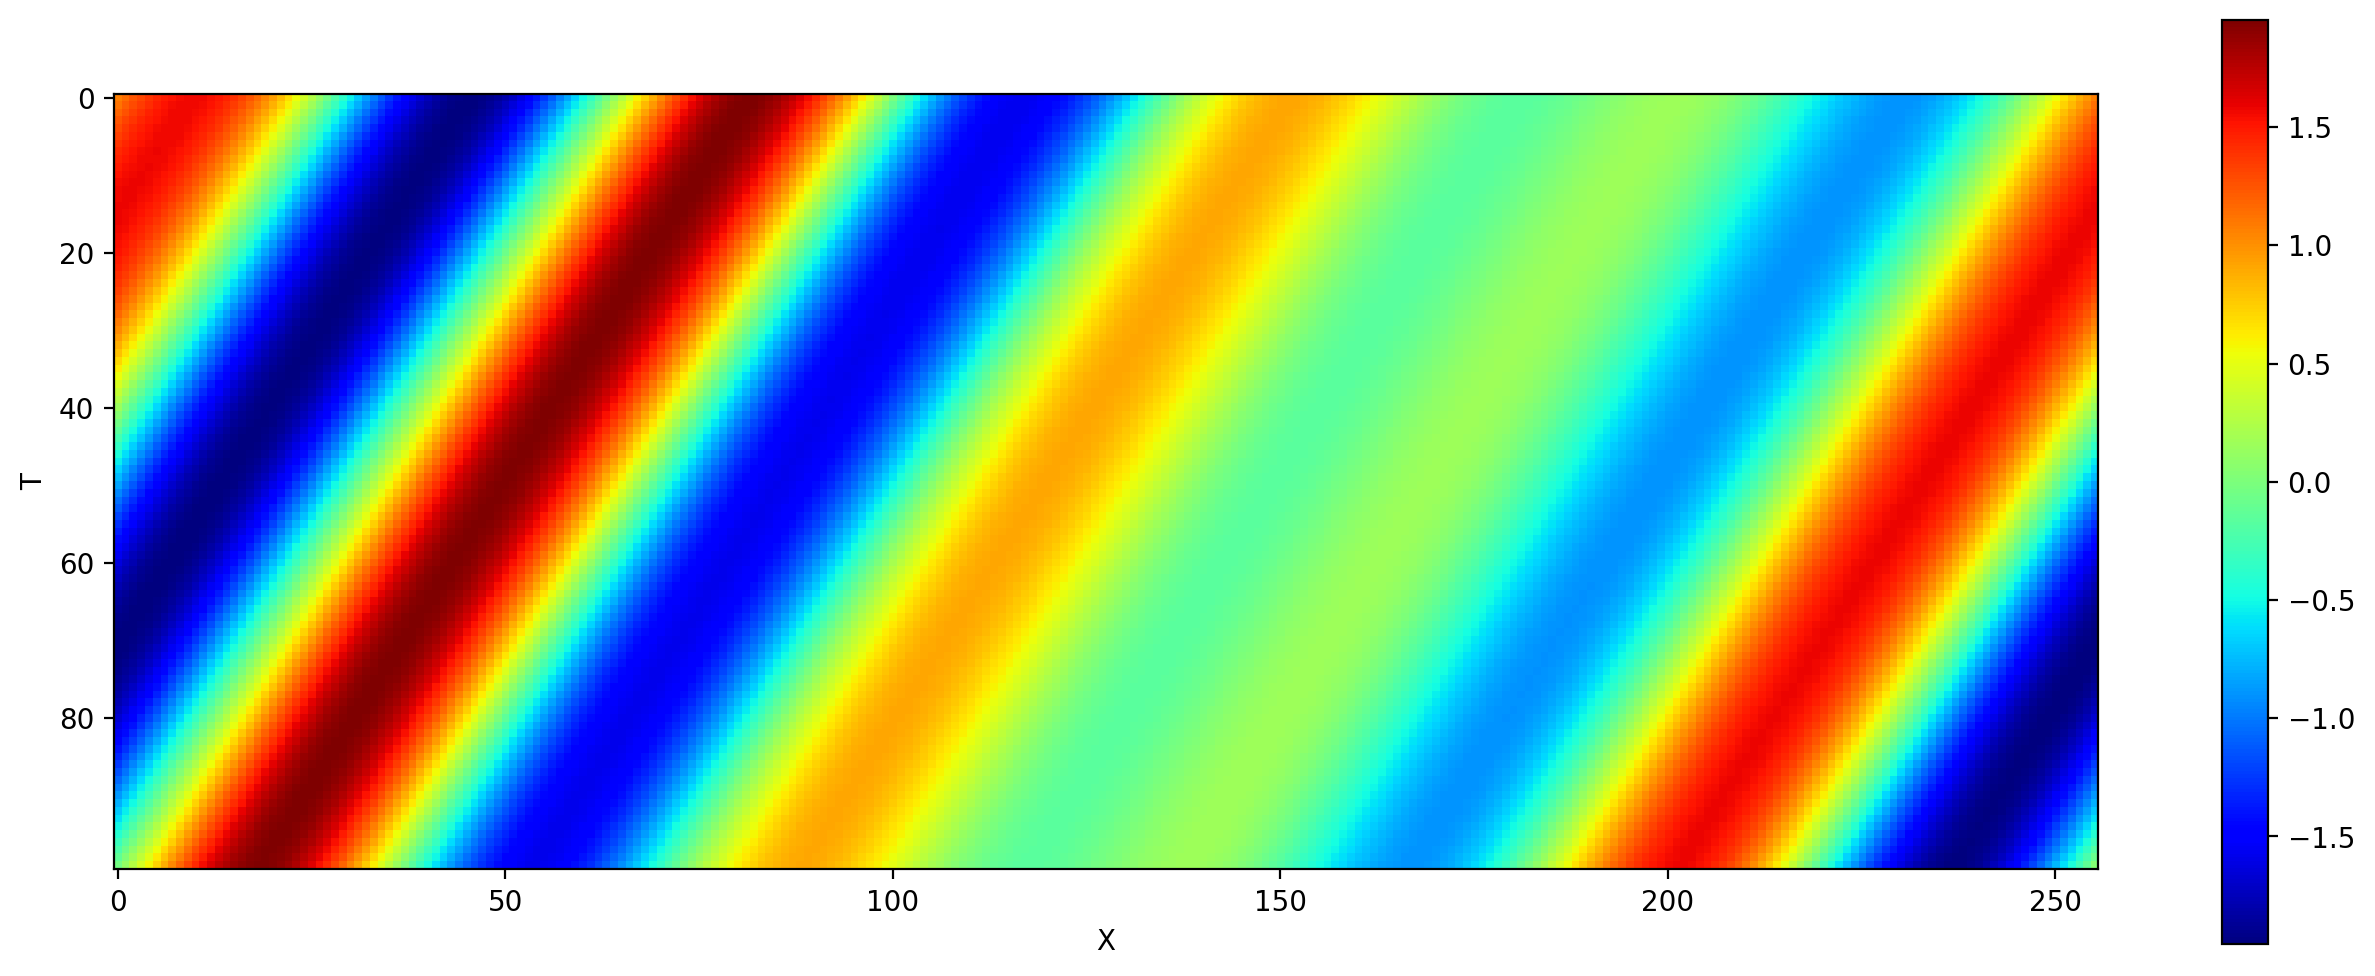

In [3]:
# define boundary conditions
boundary_type_left = PERIODIC
boundary_type_right = PERIODIC

boundary_value_type_left = PERIODIC_NA
boundary_value_type_right = PERIODIC_NA


boundary_values = torch.from_numpy(
    np.array([[boundary_type_left, 0, boundary_value_type_left, 0, 0,
               boundary_type_right, 0, boundary_value_type_right, 0, 0]])
).float().to(device)

# define the grids we solve on
a, b = np.meshgrid(t_coords.cpu().numpy(), x_coords.cpu().numpy())
grid = torch.from_numpy(np.stack([b, a], axis=-1)).to(device)
grid = grid.reshape(-1, 2)

with open('LLM_embeddings.pkl', 'rb') as file:
    loaded_embeddings_dict = pickle.load(file)

# load the LLM embedings.
# each term corresponds to c_01, c_02, c_03, c_11, c_12, c_13, s_type, kappa_type
# for c_ij, we use 0 to indicate a zero term and 1 to indicate a non-zero term.
# for s_type and kappa_type we use 0 to indicate a zero function, 1 to indicate a constant function,
# and 2 to indicate a spatial varying function.


llm_key = (0, 0, 0, 1, 0, 0, 0, 0)
llm_emb = torch.from_numpy(loaded_embeddings_dict[llm_key]).to(device)

# define initial conditions
ic = -torch.sin(3 * np.pi * x_coords) +torch.sin(4 *np.pi * x_coords)
ic = ic[:, :, None].to(device)
# define polynominal f_0 and f_1
f0 = torch.tensor([[0, 0, 0, 0]]).float().to(device) # should set this to [0, c_01, c_02, c_03]
f1 = torch.tensor([[0, 0.5, 0, 0]]).float().to(device) # should set this to [0, c_11, c_12, c_13]

# define kappa
kappa = (torch.zeros(1, 256)).to(device)

# define the source term (external force term)
s = torch.zeros(1, 256).to(device)

out = Unisolver_1D(
    ic, kappa, s, f0, f1, boundary_values,grid,llm_emb
)
out = out.squeeze().reshape(ic.shape[0], 256, 100)
import matplotlib.pyplot as plt
plt.figure(dpi=200, figsize=(16, 6))
plt.xlabel('X')  
plt.ylabel('T')  
rotated_solution = np.rot90(out[0].detach().cpu().numpy())
plt.imshow(rotated_solution, cmap='jet')
plt.colorbar()
plt.show()

#### Solving the Viscous Burgers' Equation with periodic boundary condition

- PDE form: $u_{t} + (\frac{1}{2}u^2 - \kappa u_x)_x = 0, \kappa=0.001$

- Initial condition: $u(0,x) = \cos(7\pi x) + 1$

- Boundary conditions: periodic boundary condition

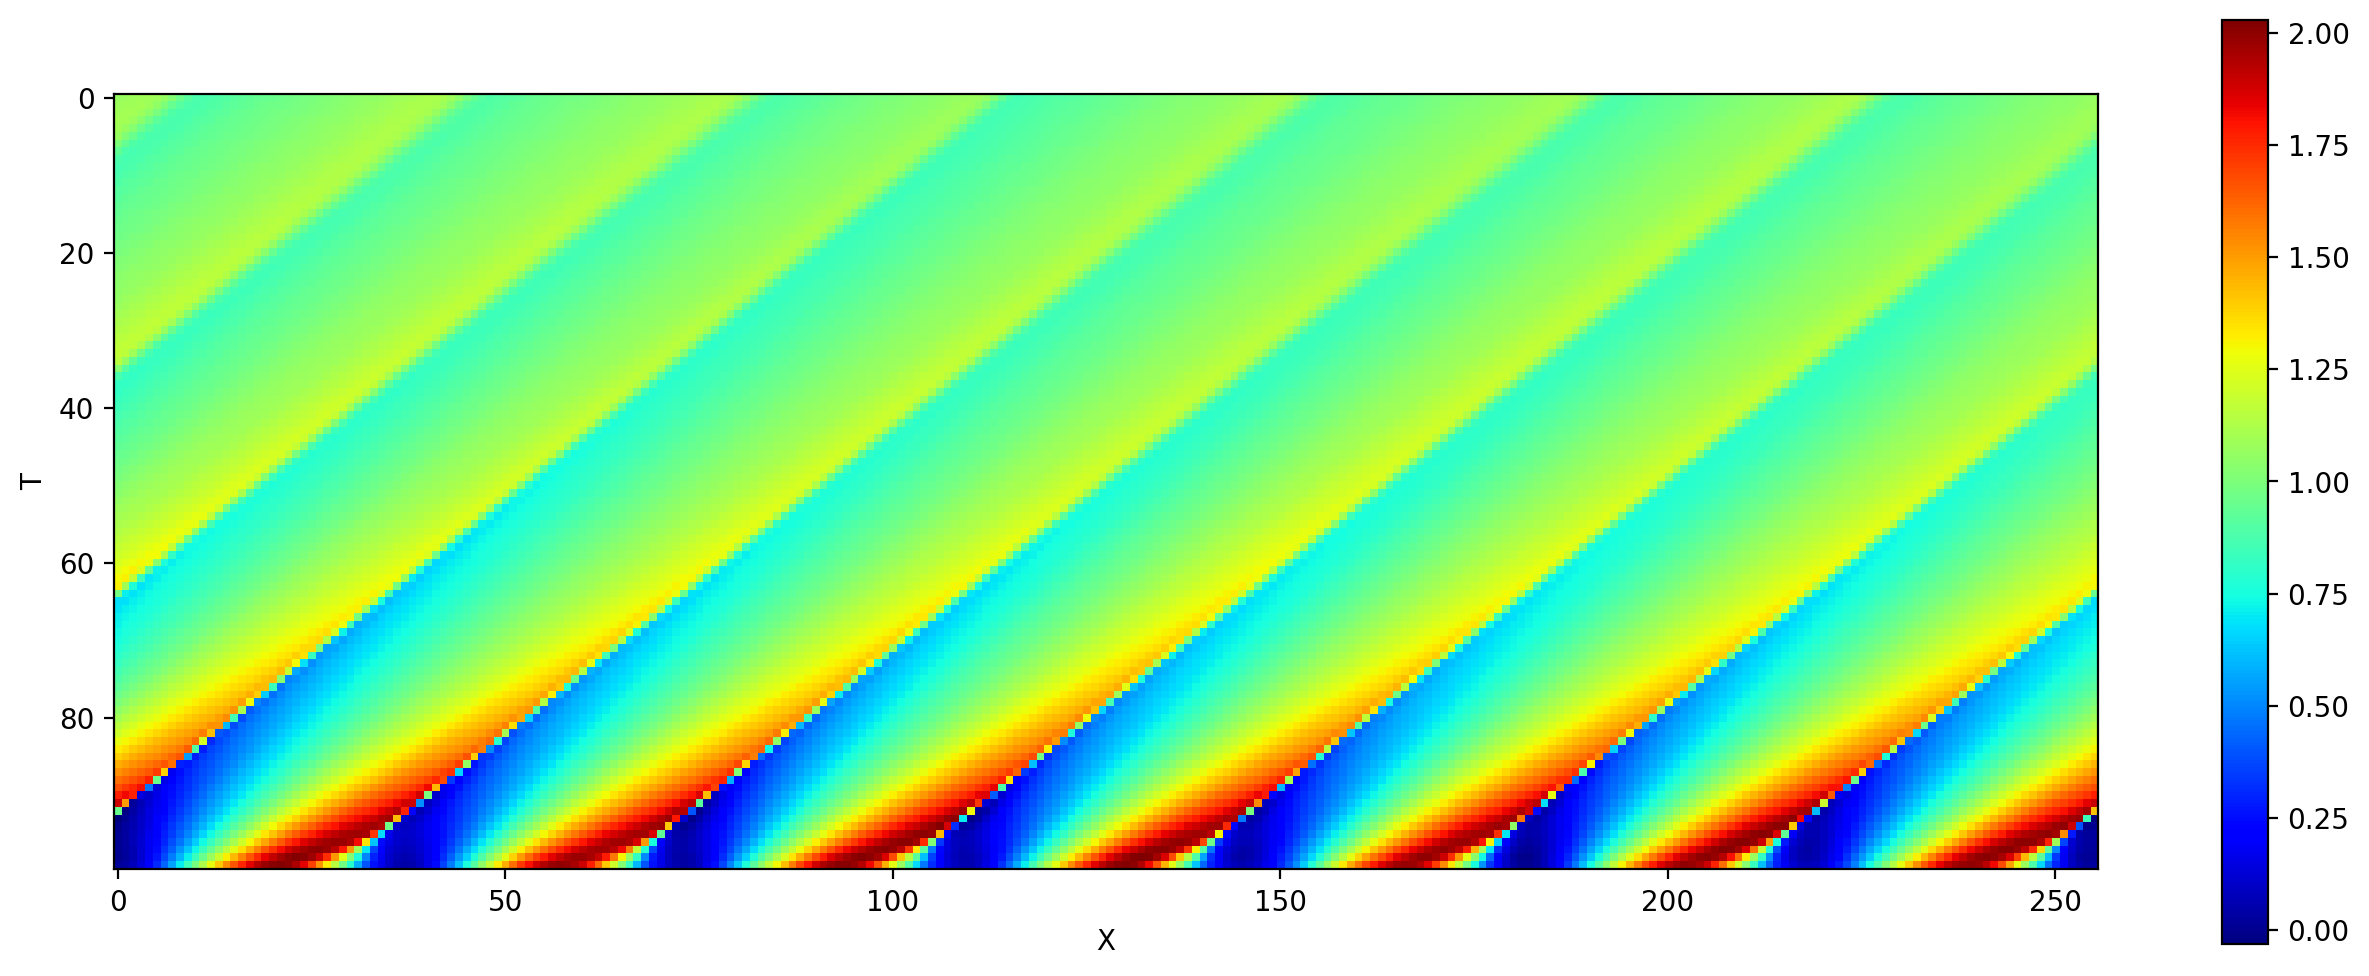

In [4]:
# define boundary conditions
boundary_type_left = PERIODIC
boundary_type_right = PERIODIC

boundary_value_type_left = PERIODIC_NA
boundary_value_type_right = PERIODIC_NA


boundary_values = torch.from_numpy(
    np.array([[boundary_type_left, 0, boundary_value_type_left, 0, 0,
               boundary_type_right, 0, boundary_value_type_right, 0, 0]])
).float().to(device)

# define the grids we solve on
a, b = np.meshgrid(t_coords.cpu().numpy(), x_coords.cpu().numpy())
grid = torch.from_numpy(np.stack([b, a], axis=-1)).to(device)
grid = grid.reshape(-1, 2)

with open('LLM_embeddings.pkl', 'rb') as file:
    loaded_embeddings_dict = pickle.load(file)

# load the LLM embedings.
# each term corresponds to c_01, c_02, c_03, c_11, c_12, c_13, s_type, kappa_type
# for c_ij, we use 0 to indicate a zero term and 1 to indicate a non-zero term.
# for s_type and kappa_type we use 0 to indicate a zero function, 1 to indicate a constant function,
# and 2 to indicate a spatial varying function.

llm_key = (0, 0, 0, 0, 1, 0, 0, 1)
llm_emb = torch.from_numpy(loaded_embeddings_dict[llm_key]).to(device)

# define initial conditions
ic = torch.cos(7 * np.pi * x_coords) + 1
ic = ic[:, :, None].to(device)
# define polynominal f_0 and f_1
f0 = torch.tensor([[0, 0, 0, 0]]).float().to(device) # should set this to [0, c_01, c_02, c_03]
f1 = torch.tensor([[0, 0, 0.5, 0]]).float().to(device) # should set this to [0, c_11, c_12, c_13]

# define kappa
kappa = 0.001 * (torch.ones(1, 256)).to(device)

# define the source term (external force term)
s = torch.zeros(1, 256).to(device)

# solve and visualization
out = Unisolver_1D(
    ic, kappa, s, f0, f1, boundary_values,grid,llm_emb
)
out = out.squeeze().reshape(ic.shape[0], 256, 100)
import matplotlib.pyplot as plt
plt.figure(dpi=200, figsize=(16, 6))
plt.xlabel('X')  
plt.ylabel('T')  
rotated_solution = np.rot90(out[0].detach().cpu().numpy())
plt.imshow(rotated_solution, cmap='jet')
plt.colorbar()
plt.show()

#### Solving the Diffusion-reaction function with periodic boundary condition

- PDE form: $u_{t} + u - (\kappa u_x)_x = 0, \kappa=0.01$

- Initial condition: $u(0,x) = \cos(6\pi x) + 2$

- Boundary conditions: periodic boundary condition

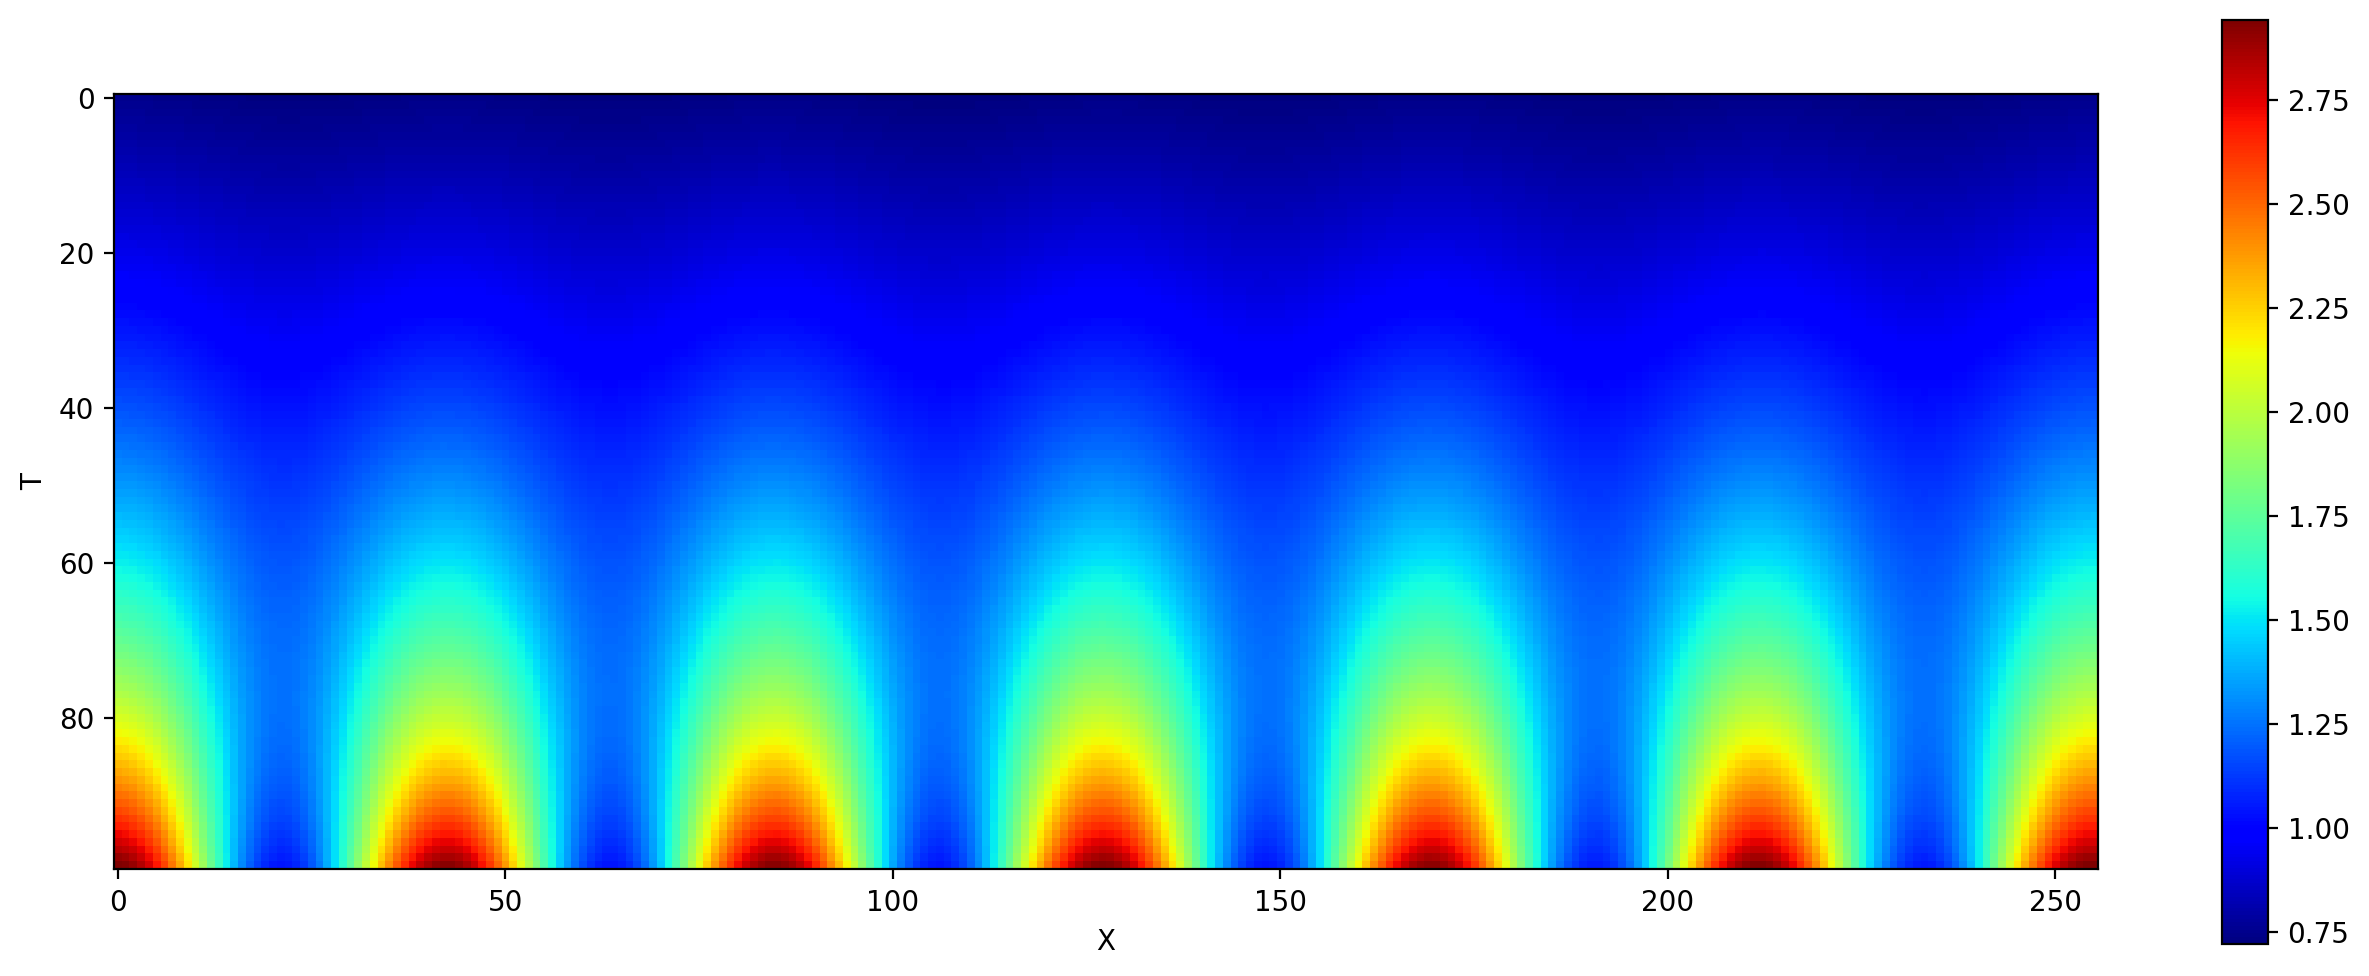

In [5]:
# define boundary conditions
boundary_type_left = PERIODIC
boundary_type_right = PERIODIC

boundary_value_type_left = PERIODIC_NA
boundary_value_type_right = PERIODIC_NA


boundary_values = torch.from_numpy(
    np.array([[boundary_type_left, 0, boundary_value_type_left, 0, 0,
               boundary_type_right, 0, boundary_value_type_right, 0, 0]])
).float().to(device)

# define the grids we solve on
a, b = np.meshgrid(t_coords.cpu().numpy(), x_coords.cpu().numpy())
grid = torch.from_numpy(np.stack([b, a], axis=-1)).to(device)
grid = grid.reshape(-1, 2)

with open('LLM_embeddings.pkl', 'rb') as file:
    loaded_embeddings_dict = pickle.load(file)

# load the LLM embedings.
# each term corresponds to c_01, c_02, c_03, c_11, c_12, c_13, s_type, kappa_type
# for c_ij, we use 0 to indicate a zero term and 1 to indicate a non-zero term.
# for s_type and kappa_type we use 0 to indicate a zero function, 1 to indicate a constant function,
# and 2 to indicate a spatial varying function.

llm_key = (1, 0, 0, 0, 0, 0, 0, 1)
llm_emb = torch.from_numpy(loaded_embeddings_dict[llm_key]).to(device)

# define initial conditions
ic = torch.cos(6 * np.pi * x_coords) + 2
ic = ic[:, :, None].to(device)
# define polynominal f_0 and f_1
f0 = torch.tensor([[0, 1, 0, 0]]).float().to(device) # should set this to [0, c_01, c_02, c_03]
f1 = torch.tensor([[0, 0, 0, 0]]).float().to(device) # should set this to [0, c_11, c_12, c_13]

# define kappa
kappa = 0.01 * (torch.ones(1, 256)).to(device)

# define the source term (external force term)
s = torch.zeros(1, 256).to(device)

# solve and visualization
out = Unisolver_1D(
    ic, kappa, s, f0, f1, boundary_values,grid,llm_emb
)
out = out.squeeze().reshape(ic.shape[0], 256, 100)
import matplotlib.pyplot as plt
plt.figure(dpi=200, figsize=(16, 6))
plt.xlabel('X')  
plt.ylabel('T')  
rotated_solution = np.rot90(out[0].detach().cpu().numpy())
plt.imshow(rotated_solution, cmap='jet')
plt.colorbar()
plt.show()

#### Solving a general form 1D PDE with non-periodic boundary condition

- PDE form: $u_{t} + u^2 + u^3 + (-0.5u -0.5 u^3 - \kappa u_x)_x = 0, \kappa=0.01$

- Initial condition: $u(0,x) = \sin(6 * \pi x)$

- Boundary conditions: Left: Dirichlet boundary condition with ($u|_{x=-1}=-1$);
Right: Robin boundary condition with ($0.8 u|_{x=1} + 0.6 u_x|_{x=1}=2$)

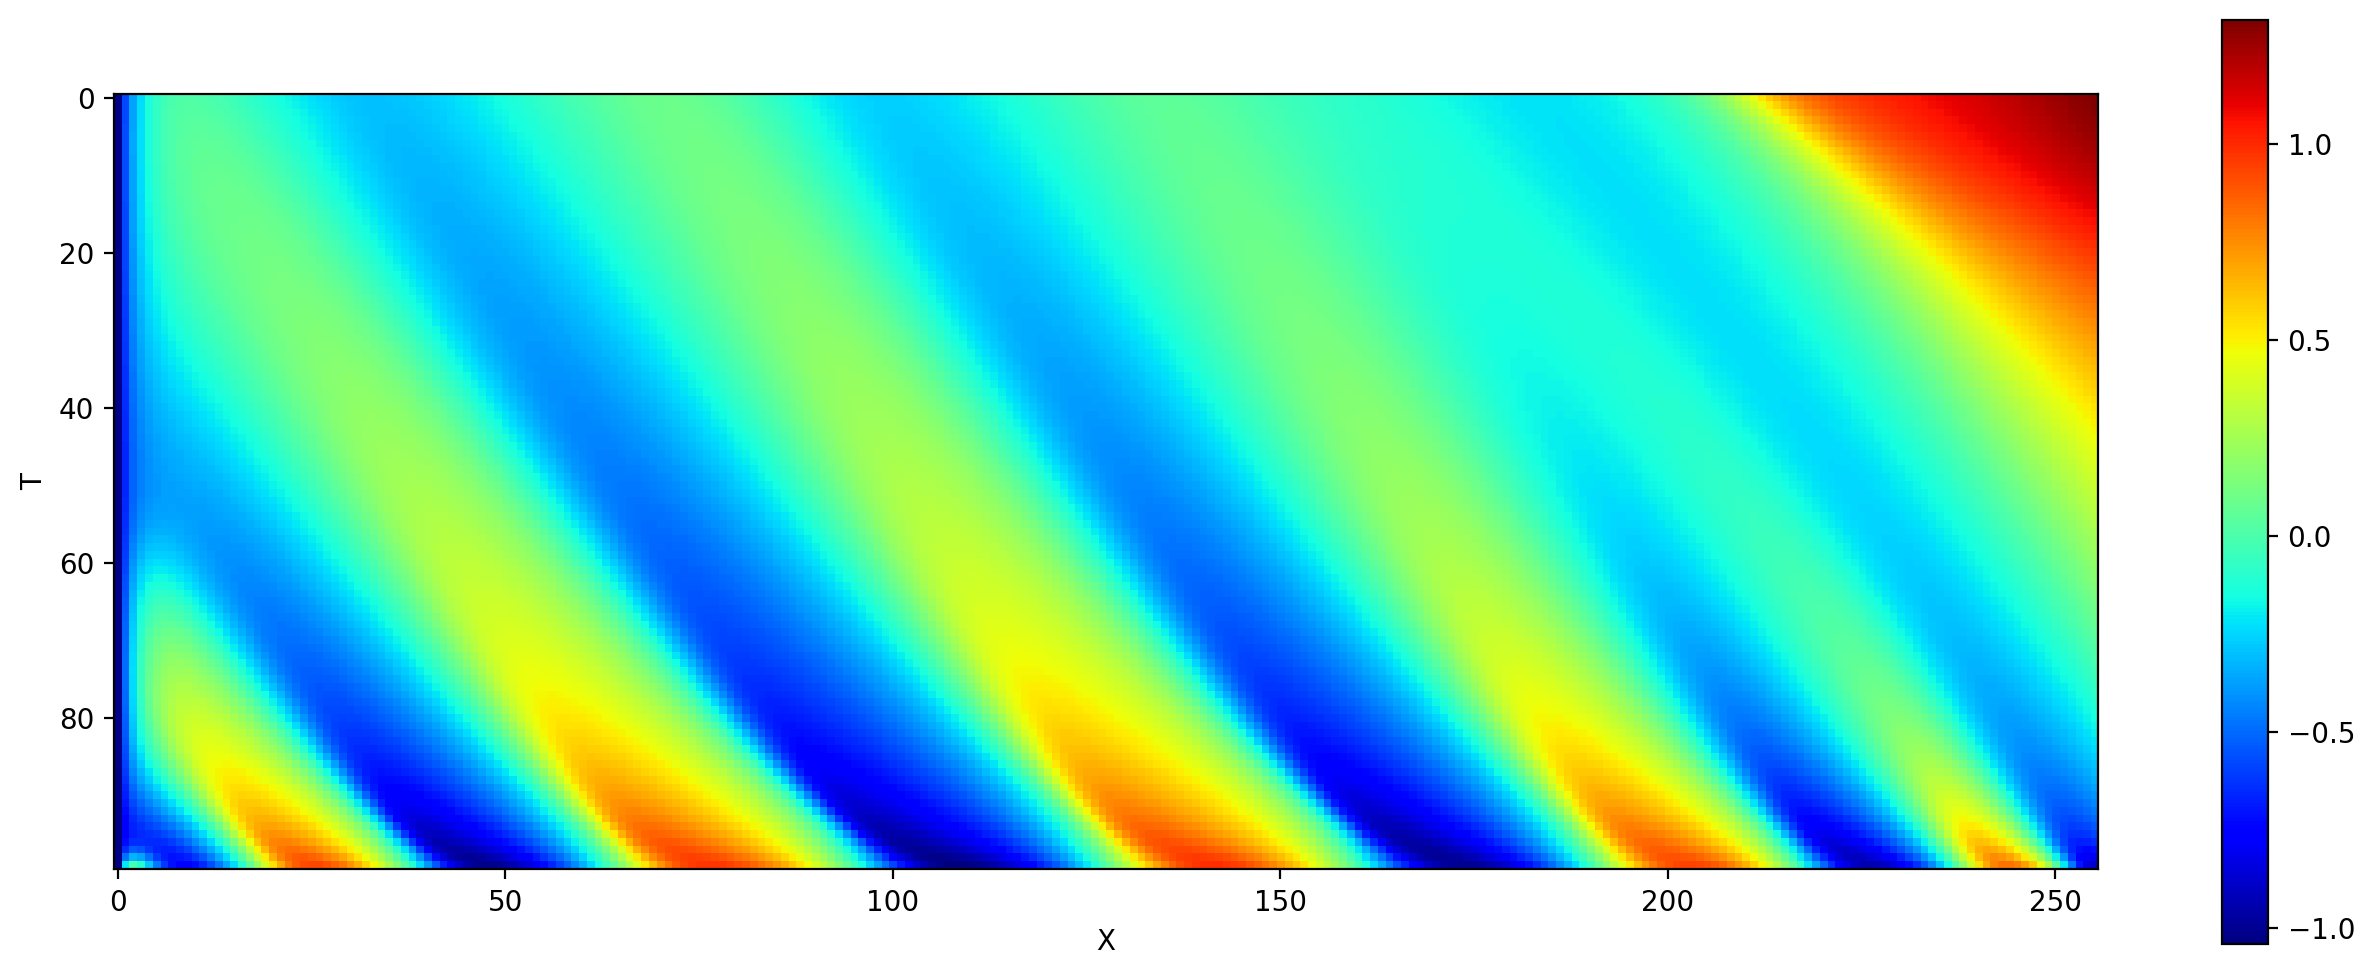

In [6]:
# define boundary conditions
boundary_type_left = DIRICHLET
boundary_type_right = ROBIN

boundary_value_type_left = RAND_VALUE
boundary_value_type_right = RAND_VALUE


boundary_values = torch.from_numpy(
    np.array([[boundary_type_left, -1, boundary_value_type_left, 0, 1,
               boundary_type_right, 2, boundary_value_type_right, 0.6, 0.8]])
).float().to(device)

# define the grids we solve on
a, b = np.meshgrid(t_coords.cpu().numpy(), x_coords.cpu().numpy())
grid = torch.from_numpy(np.stack([b, a], axis=-1)).to(device)
grid = grid.reshape(-1, 2)

with open('LLM_embeddings.pkl', 'rb') as file:
    loaded_embeddings_dict = pickle.load(file)

# load the LLM embedings.
# each term corresponds to c_01, c_02, c_03, c_11, c_12, c_13, s_type, kappa_type
# for c_ij, we use 0 to indicate a zero term and 1 to indicate a non-zero term.
# for s_type and kappa_type we use 0 to indicate a zero function, 1 to indicate a constant function,
# and 2 to indicate a spatial varying function.

llm_key = (0, 1, 1, 1, 0, 1, 0, 1)
llm_emb = torch.from_numpy(loaded_embeddings_dict[llm_key]).to(device)

# define initial conditions
ic = torch.sin(6 * np.pi * x_coords)
ic = ic[:, :, None].to(device)
# define polynominal f_0 and f_1
f0 = torch.tensor([[0, 0, 1, 1]]).float().to(device) # should set this to [0, c_01, c_02, c_03]
f1 = torch.tensor([[0, -0.5, 0, -0.5]]).float().to(device) # should set this to [0, c_11, c_12, c_13]

# define kappa
kappa = 0.01 * (torch.ones(1, 256)).to(device)

# define the source term (external force term)
s = torch.zeros(1, 256).to(device)

# solve and visualization
out = Unisolver_1D(
    ic, kappa, s, f0, f1, boundary_values,grid,llm_emb
)
out = out.squeeze().reshape(ic.shape[0], 256, 100)
import matplotlib.pyplot as plt
plt.figure(dpi=200, figsize=(16, 6))
plt.xlabel('X')  
plt.ylabel('T')  
rotated_solution = np.rot90(out[0].detach().cpu().numpy())
plt.imshow(rotated_solution, cmap='jet')
plt.colorbar()
plt.show()